# 1. Setup

## 1.1 Install Dependencies

Run this pip install if you are using Apple Silicon to use the GPU.

In [1]:
%pip install tensorflow-macos tensorflow-metal

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs:", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
%pip install tensorflow opencv-python matplotlib

## 1.2 Import Dependencies

In [3]:
# Import standard libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [4]:
# Import TensorFlow dependencies - functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Layer
import tensorflow as tf

## 1.3 Create Folder Strutures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

# 2. Collect Postives and Anchors

## 2.1 Retrieve Labelled Faces in the Wild Dataset

Installing another package - retrieves the required dataset from kaggle

In [14]:
%pip install kagglehub

  Using cached kagglehub-0.3.12-py3-none-any.whl.metadata (38 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached kagglehub-0.3.12-py3-none-any.whl (67 kB)
Using cached PyYAML-6.0.2-cp39-cp39-macosx_11_0_arm64.whl (172 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [kagglehub]
Note: you may need to restart the kernel to use updated packages.


Using Kaggles API to download the dataset locally to your computer.

You may need to create a Kaggle Account and create an API key.

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

print("Path to dataset files:", path)

/opt/anaconda3/envs/deepface/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 112M/112M [00:04<00:00, 24.7MB/s] 

Extracting files...


Path to dataset files: /Users/ethanvillalovoz/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4


The downloaded dataset was stored in my .cache directory of my machine.

Moves it to the current working directory you are coding this project in.

In [16]:
import shutil
import os

# Source path (where KaggleHub downloaded the dataset)
src_path = "/Users/ethanvillalovoz/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4"

# Destination path (your project directory, e.g., 'data/lfw-dataset')
dst_path = os.path.join(os.getcwd(), "data", "lfw-dataset")

# Move the directory
if not os.path.exists(dst_path):
    shutil.move(src_path, dst_path)
    print(f"Dataset moved to: {dst_path}")
else:
    print("Destination already exists. Remove it first if you want to overwrite.")

Dataset moved to: /Users/ethanvillalovoz/Desktop/deepface-oneshot-paper-reimplementation/data/lfw-dataset


Moves all of the images from the dataset into our negative image folder

In [ ]:
for directory in os.listdir(dst_path):
    if directory.startswith("lfw-deepfunneled"):
        src_dir = os.path.join(dst_path, directory)
        for sub_directory in os.listdir(src_dir):
            if directory.startswith("lfw-deepfunneled"):
                sub_dir_path = os.path.join(src_dir, sub_directory)
                for filename in os.listdir(sub_dir_path):
                    filename_path = os.path.join(sub_dir_path, filename)
                    for image in os.listdir(filename_path):
                        if image.endswith(".jpg"):
                            image_path = os.path.join(filename_path, image)
                            print(f"Processing image: {image_path}")
                            final_dst_path = os.path.join(NEG_PATH, image)
                            print(f"dst_path: {final_dst_path}")
                            shutil.move(image_path, final_dst_path)
                            print(f"Moved {image_path} to {final_dst_path}")

## 2.2 Collect Positive and Anchor Classes

In [5]:
# Import uuid library for unique file names
import uuid

In [8]:
# Establish connection to the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    frame = frame[120:120+250, 120:120+250, :]  # Crop the frame to a square

    # Collect anchor images
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Create a unique filename using uuid
        imgname = os.path.join(ANC_PATH, f"{uuid.uuid1()}.jpg")
        # Wrute the image to the anchor path
        cv2.imwrite(imgname, frame)

    # Collect positive images
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Create a unique filename using uuid
        imgname = os.path.join(POS_PATH, f"{uuid.uuid1()}.jpg")
        # Wrute the image to the anchor path
        cv2.imwrite(imgname, frame)

    # Display the frame
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [6]:
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(300)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(300)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(300)

2025-05-26 14:20:38.518048: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-26 14:20:38.518107: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-26 14:20:38.518113: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-05-26 14:20:38.518165: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 14:20:38.518182: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 3.2 Preprocessing - Scale and Resize

In [7]:
def preprocess_image(image_path):

    # Read in image from path
    image = tf.io.read_file(image_path)

    # Load in the image
    image = tf.image.decode_jpeg(image)

    # Preprocessing steps
    # Resize the image to a fixed size 105x105x3
    image = tf.image.resize(image, [105, 105])
    image = (image / 255.0)  # Normalize to [0, 1]

    # Return the processed image
    return image

## 3.3 Create Labelled Dataset

In [53]:
# (anchor, positive) => 1,1,1,1
# (anchor, negative) => 0,0,0,0

In [8]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
# Combine the datasets
dataset = positives.concatenate(negatives)

In [9]:
example = dataset.as_numpy_iterator().next()
print("Example from dataset:")
print("Anchor:", example[0])
print("Positive:", example[1])
print("Label:", example[2])

Example from dataset:
Anchor: b'data/anchor/cf7df946-3a55-11f0-bb5e-acde48001122.jpg'
Positive: b'data/positive/433db736-3a56-11f0-bb5e-acde48001122.jpg'
Label: 1.0


## 3.4 Build Train and Test Partition

In [10]:
def preprocess_image_twin(input_img, value_img, label):
    input_img = preprocess_image(input_img)
    value_img = preprocess_image(value_img)
    return (input_img, value_img, label)

In [11]:
res = preprocess_image_twin(*example)

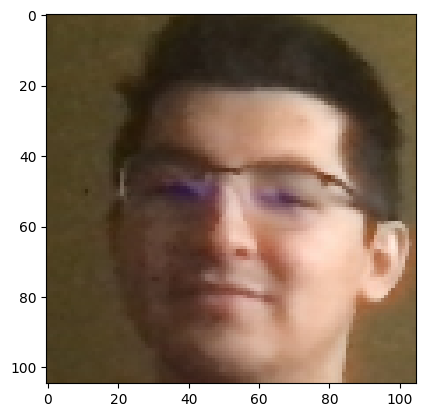

In [12]:
plt.imshow(res[1])

In [13]:
# Build dataLoader pipeline
data = dataset.map(preprocess_image_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [14]:
# Training partition
train_data = data.take(round(len(data) * 0.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [15]:
# Testing partition
test_data = data.skip(round(len(data) * 0.8))
test_data = test_data.take(round(len(data) * 0.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [16]:
def making_embedding_model():
    # Input layer
    input_img = Input(shape=(105, 105, 3), name='input_image')

    # Convolutional layers

    # First convolutional layer
    c1 = Conv2D(64, (10, 10), activation='relu')(input_img)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

    # Second convolutional layer
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

    # Third convolutional layer
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

    # Fourth convolutional layer
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=input_img, outputs=d1, name='embedding_model')

In [22]:
embedding = making_embedding_model()
# Create the embedding model
embedding.summary()

Model: "embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [23]:
# Siamese L1 Distance class
class L1Distance(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Similarity calculation
    def call(self, input_embedding, value_embedding):
        # Calculate the absolute difference
        return tf.math.abs(input_embedding - value_embedding)


## 4.3 Make Siamese Model

In [24]:
def make_siamese_network():
    
    # Anchor image input in the network
    input_image = Input(shape=(105, 105, 3), name='input_image')

    # Validation image input in the network
    validation_image = Input(shape=(105, 105, 3), name='validation_image')

    # Combine siamese distance components
    siamese_layer = L1Distance()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classification = Dense(1, activation='sigmoid', name='classification')(distances)

    return Model(inputs=[input_image, validation_image], outputs=[classification], name='siamese_network')

In [25]:
siamese_model = make_siamese_network()
siamese_model.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_model     │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_distance_2       │ (None, 4096)      │          0 │ embedding_model[… │
│ (L1Distance)        │                   │            │ embedding_model[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │      4,097 │ l1_distance_2[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [26]:
binary_cross_entropy = tf.losses.BinaryCrossentropy()

In [27]:
opt = tf.keras.optimizers.Adam(1e-4) # Learning rate 0.0001

## 5.2 Establish Checkpoints

In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [29]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        
        # Get anchor and positive/negative images
        X = batch[:2]

        # Get the labels
        y = batch[2]

        # Forward pass
        y_pred = siamese_model(X, training=True)
        
        # Calculate the loss
        loss = binary_cross_entropy(y, y_pred)

    # Calculate the gradients
    gradients = tape.gradient(loss, siamese_model.trainable_variables)

    # Apply the gradients
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))

    return loss


## 5.4 Build Training Loop

In [30]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [64]:
def train(data, EPOCHS=10):
    loss_history = []
    precision_history = []
    recall_history = []
    
    for epoch in range(1, EPOCHS + 1):
        print(f"\n Epoch {epoch}/{EPOCHS} \n")
        progbar = tf.keras.utils.Progbar(len(data))

        precision = Precision()
        recall = Recall()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            y_pred = siamese_model(batch[:2])
            precision.update_state(batch[2], y_pred)
            recall.update_state(batch[2], y_pred)

        print(f"Loss: {loss.numpy()}")
        print(f"Precision: {precision.result().numpy()}")
        print(f"Recall: {recall.result().numpy()}")

        # Save checkpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"Checkpoint saved at epoch {epoch}")

        # Store metrics
        loss_history.append(loss.numpy())
        precision_history.append(precision.result().numpy())
        recall_history.append(recall.result().numpy())
    
    return loss_history, precision_history, recall_history

## 5.5 Train the model

In [33]:
EPOCHS = 100

In [65]:
loss_history, precision_history, recall_history = train(train_data, EPOCHS=EPOCHS)


 Epoch 1/100 



2025-05-27 15:16:13.814199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.2740451893478166e-06
Precision: 1.0
Recall: 1.0

 Epoch 2/100 



2025-05-27 15:16:32.478384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.417038311046781e-05
Precision: 1.0
Recall: 1.0

 Epoch 3/100 



2025-05-27 15:16:51.136473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.3939884310238995e-06
Precision: 1.0
Recall: 1.0

 Epoch 4/100 



2025-05-27 15:17:09.808581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.490840521815699e-06
Precision: 1.0
Recall: 1.0

 Epoch 5/100 



2025-05-27 15:17:28.488120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 8.932946911954787e-06
Precision: 1.0
Recall: 1.0

 Epoch 6/100 



2025-05-27 15:17:47.164823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.4793333725247066e-06
Precision: 1.0
Recall: 1.0

 Epoch 7/100 



2025-05-27 15:18:05.842064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 9.91632987279445e-06
Precision: 1.0
Recall: 1.0

 Epoch 8/100 



2025-05-27 15:18:24.515430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.9173695515492e-07
Precision: 1.0
Recall: 1.0

 Epoch 9/100 



2025-05-27 15:18:43.201692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.4901160305669237e-08
Precision: 1.0
Recall: 1.0

 Epoch 10/100 



2025-05-27 15:19:01.939851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.3170234271674417e-05
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 10

 Epoch 11/100 



2025-05-27 15:19:20.849867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.645299355208408e-05
Precision: 1.0
Recall: 1.0

 Epoch 12/100 



2025-05-27 15:19:39.512014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.4610413826594595e-06
Precision: 1.0
Recall: 1.0

 Epoch 13/100 



2025-05-27 15:19:58.192163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.5944056031003129e-06
Precision: 1.0
Recall: 1.0

 Epoch 14/100 



2025-05-27 15:20:16.846421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.1755536181444768e-06
Precision: 1.0
Recall: 1.0

 Epoch 15/100 



2025-05-27 15:20:35.517919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.9917221076611895e-06
Precision: 1.0
Recall: 1.0

 Epoch 16/100 



2025-05-27 15:20:54.176677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.4386099792318419e-05
Precision: 1.0
Recall: 1.0

 Epoch 17/100 



2025-05-27 15:21:12.835835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.564621072702721e-07
Precision: 1.0
Recall: 1.0

 Epoch 18/100 



2025-05-27 15:21:31.481621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.3543470888398588e-06
Precision: 1.0
Recall: 1.0

 Epoch 19/100 



2025-05-27 15:21:50.144217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.3841835172788706e-07
Precision: 1.0
Recall: 1.0

 Epoch 20/100 



2025-05-27 15:22:08.790060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.9371495341147238e-07
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 20

 Epoch 21/100 



2025-05-27 15:22:27.671724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.0116556243010564e-07
Precision: 1.0
Recall: 1.0

 Epoch 22/100 



2025-05-27 15:22:46.348591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.1219588486710563e-05
Precision: 1.0
Recall: 1.0

 Epoch 23/100 



2025-05-27 15:23:05.076351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.5448450691765174e-07
Precision: 1.0
Recall: 1.0

 Epoch 24/100 



2025-05-27 15:23:23.749159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.7820566426962614e-05
Precision: 1.0
Recall: 1.0

 Epoch 25/100 



2025-05-27 15:23:42.422701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.5464333905110834e-06
Precision: 1.0
Recall: 1.0

 Epoch 26/100 



2025-05-27 15:24:01.094930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.576274707484117e-07
Precision: 1.0
Recall: 1.0

 Epoch 27/100 



2025-05-27 15:24:19.752566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.0952059710689355e-05
Precision: 1.0
Recall: 1.0

 Epoch 28/100 



2025-05-27 15:24:38.405427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.65476193514769e-06
Precision: 1.0
Recall: 1.0

 Epoch 29/100 



2025-05-27 15:24:57.068390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.301554774130636e-07
Precision: 1.0
Recall: 1.0

 Epoch 30/100 



2025-05-27 15:25:15.725397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.11429380417394e-06
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 30

 Epoch 31/100 



2025-05-27 15:25:34.603600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.00665055369609e-06
Precision: 1.0
Recall: 1.0

 Epoch 32/100 



2025-05-27 15:25:53.252734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.428863126624492e-06
Precision: 1.0
Recall: 1.0

 Epoch 33/100 



2025-05-27 15:26:11.916372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.159811048040865e-06
Precision: 1.0
Recall: 1.0

 Epoch 34/100 



2025-05-27 15:26:30.526563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.650774544894375e-07
Precision: 1.0
Recall: 1.0

 Epoch 35/100 



2025-05-27 15:26:49.137491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 6.571272933797445e-06
Precision: 1.0
Recall: 1.0

 Epoch 36/100 



2025-05-27 15:27:07.751014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.733462553005666e-06
Precision: 1.0
Recall: 1.0

 Epoch 37/100 



2025-05-27 15:27:26.373584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.0935985958203673e-06
Precision: 1.0
Recall: 1.0

 Epoch 38/100 



2025-05-27 15:27:45.030521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.1308298983058194e-06
Precision: 1.0
Recall: 1.0

 Epoch 39/100 



2025-05-27 15:28:03.665416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.8071862036304083e-06
Precision: 1.0
Recall: 1.0

 Epoch 40/100 



2025-05-27 15:28:22.304755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 9.313159807788907e-07
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 40

 Epoch 41/100 



2025-05-27 15:28:41.165156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.086160861836106e-07
Precision: 1.0
Recall: 1.0

 Epoch 42/100 



2025-05-27 15:28:59.844093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 6.481994319074147e-07
Precision: 1.0
Recall: 1.0

 Epoch 43/100 



2025-05-27 15:29:18.522280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.4437499632767867e-06
Precision: 1.0
Recall: 1.0

 Epoch 44/100 



2025-05-27 15:29:37.241421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.2931216082943138e-06
Precision: 1.0
Recall: 1.0

 Epoch 45/100 



2025-05-27 15:29:55.955236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 6.101915460021701e-06
Precision: 1.0
Recall: 1.0

 Epoch 46/100 



2025-05-27 15:30:14.603692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.0
Precision: 1.0
Recall: 1.0

 Epoch 47/100 



2025-05-27 15:30:33.286211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.725289587919178e-08
Precision: 1.0
Recall: 1.0

 Epoch 48/100 



2025-05-27 15:30:51.946850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.477646143641323e-06
Precision: 1.0
Recall: 1.0

 Epoch 49/100 



2025-05-27 15:31:10.595373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.038170118292328e-06
Precision: 1.0
Recall: 1.0

 Epoch 50/100 



2025-05-27 15:31:29.235068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.2351740014414645e-08
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 50

 Epoch 51/100 



2025-05-27 15:31:48.081145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.743416987665114e-06
Precision: 1.0
Recall: 1.0

 Epoch 52/100 



2025-05-27 15:32:06.741671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.3676187740638852e-06
Precision: 1.0
Recall: 1.0

 Epoch 53/100 



2025-05-27 15:32:25.380359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.382491740921978e-06
Precision: 1.0
Recall: 1.0

 Epoch 54/100 



2025-05-27 15:32:44.004005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.27825318890973e-07
Precision: 1.0
Recall: 1.0

 Epoch 55/100 



2025-05-27 15:33:02.633737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 9.163668437395245e-06
Precision: 1.0
Recall: 1.0

 Epoch 56/100 



2025-05-27 15:33:21.270550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.450580152834618e-09
Precision: 1.0
Recall: 1.0

 Epoch 57/100 



2025-05-27 15:33:39.909294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.610037987935357e-06
Precision: 1.0
Recall: 1.0

 Epoch 58/100 



2025-05-27 15:33:58.579366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 8.791624281911936e-07
Precision: 1.0
Recall: 1.0

 Epoch 59/100 



2025-05-27 15:34:17.235148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 8.717145192349562e-07
Precision: 1.0
Recall: 1.0

 Epoch 60/100 



2025-05-27 15:34:35.906201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.4304962405731203e-06
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 60

 Epoch 61/100 



2025-05-27 15:34:54.798705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.960463056453591e-08
Precision: 1.0
Recall: 1.0

 Epoch 62/100 



2025-05-27 15:35:13.444343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.823087457836664e-07
Precision: 1.0
Recall: 1.0

 Epoch 63/100 



2025-05-27 15:35:32.064702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.4901159417490817e-08
Precision: 1.0
Recall: 1.0

 Epoch 64/100 



2025-05-27 15:35:50.716450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.3485406498148222e-06
Precision: 1.0
Recall: 1.0

 Epoch 65/100 



2025-05-27 15:36:09.313399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.2037139590102015e-06
Precision: 1.0
Recall: 1.0

 Epoch 66/100 



2025-05-27 15:36:27.908731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 6.3775664784770925e-06
Precision: 1.0
Recall: 1.0

 Epoch 67/100 



2025-05-27 15:36:46.496162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.72107036178204e-06
Precision: 1.0
Recall: 1.0

 Epoch 68/100 



2025-05-27 15:37:05.135649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.479367933323374e-06
Precision: 1.0
Recall: 1.0

 Epoch 69/100 



2025-05-27 15:37:23.748364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.2351738238057806e-08
Precision: 1.0
Recall: 1.0

 Epoch 70/100 



2025-05-27 15:37:42.333597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.97207860614435e-07
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 70

 Epoch 71/100 



2025-05-27 15:38:01.158691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.0
Precision: 1.0
Recall: 1.0

 Epoch 72/100 



2025-05-27 15:38:19.773783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 6.183963705552742e-07
Precision: 1.0
Recall: 1.0

 Epoch 73/100 



2025-05-27 15:38:38.348702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 6.780000489925442e-07
Precision: 1.0
Recall: 1.0

 Epoch 74/100 



2025-05-27 15:38:56.981863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 8.344597404175147e-07
Precision: 1.0
Recall: 1.0

 Epoch 75/100 



2025-05-27 15:39:15.572805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.671427632274572e-06
Precision: 1.0
Recall: 1.0

 Epoch 76/100 



2025-05-27 15:39:34.221216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.607697808798548e-07
Precision: 1.0
Recall: 1.0

 Epoch 77/100 



2025-05-27 15:39:52.864647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.5762109291681554e-06
Precision: 1.0
Recall: 1.0

 Epoch 78/100 



2025-05-27 15:40:11.516886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.7417615910962922e-06
Precision: 1.0
Recall: 1.0

 Epoch 79/100 



2025-05-27 15:40:30.128160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.704525968511007e-06
Precision: 1.0
Recall: 1.0

 Epoch 80/100 



2025-05-27 15:40:48.708211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 8.419114578828157e-07
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 80

 Epoch 81/100 



2025-05-27 15:41:07.586226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.0248675102484412e-06
Precision: 1.0
Recall: 1.0

 Epoch 82/100 



2025-05-27 15:41:26.196978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.6763719941081945e-06
Precision: 1.0
Recall: 1.0

 Epoch 83/100 



2025-05-27 15:41:44.832754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.7583184899194748e-06
Precision: 1.0
Recall: 1.0

 Epoch 84/100 



2025-05-27 15:42:03.418410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.301547384486184e-07
Precision: 1.0
Recall: 1.0

 Epoch 85/100 



2025-05-27 15:42:22.028800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.1399336017348105e-06
Precision: 1.0
Recall: 1.0

 Epoch 86/100 



2025-05-27 15:42:40.707804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.013272253658215e-06
Precision: 1.0
Recall: 1.0

 Epoch 87/100 



2025-05-27 15:42:59.386904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.4379559161170619e-06
Precision: 1.0
Recall: 1.0

 Epoch 88/100 



2025-05-27 15:43:18.088407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.0
Precision: 1.0
Recall: 1.0

 Epoch 89/100 



2025-05-27 15:43:36.802655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.227037599477626e-07
Precision: 1.0
Recall: 1.0

 Epoch 90/100 



2025-05-27 15:43:55.509094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 6.034957209521963e-07
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 90

 Epoch 91/100 



2025-05-27 15:44:14.396517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.400693463438074e-06
Precision: 1.0
Recall: 1.0

 Epoch 92/100 



2025-05-27 15:44:33.057137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.450580152834618e-09
Precision: 1.0
Recall: 1.0

 Epoch 93/100 



2025-05-27 15:44:51.714992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.215395049162908e-07
Precision: 1.0
Recall: 1.0

 Epoch 94/100 



2025-05-27 15:45:10.377623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.3709013728657737e-06
Precision: 1.0
Recall: 1.0

 Epoch 95/100 



2025-05-27 15:45:29.056630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.587922942140722e-07
Precision: 1.0
Recall: 1.0

 Epoch 96/100 



2025-05-27 15:45:47.747543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 9.238668212674384e-07
Precision: 1.0
Recall: 1.0

 Epoch 97/100 



2025-05-27 15:46:06.394571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.874290825933713e-07
Precision: 1.0
Recall: 1.0

 Epoch 98/100 



2025-05-27 15:46:25.072471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.450580152834618e-09
Precision: 1.0
Recall: 1.0

 Epoch 99/100 



2025-05-27 15:46:43.756451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.09777567256242e-06
Precision: 1.0
Recall: 1.0

 Epoch 100/100 



2025-05-27 15:47:02.436447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.980225701776362e-07
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 100


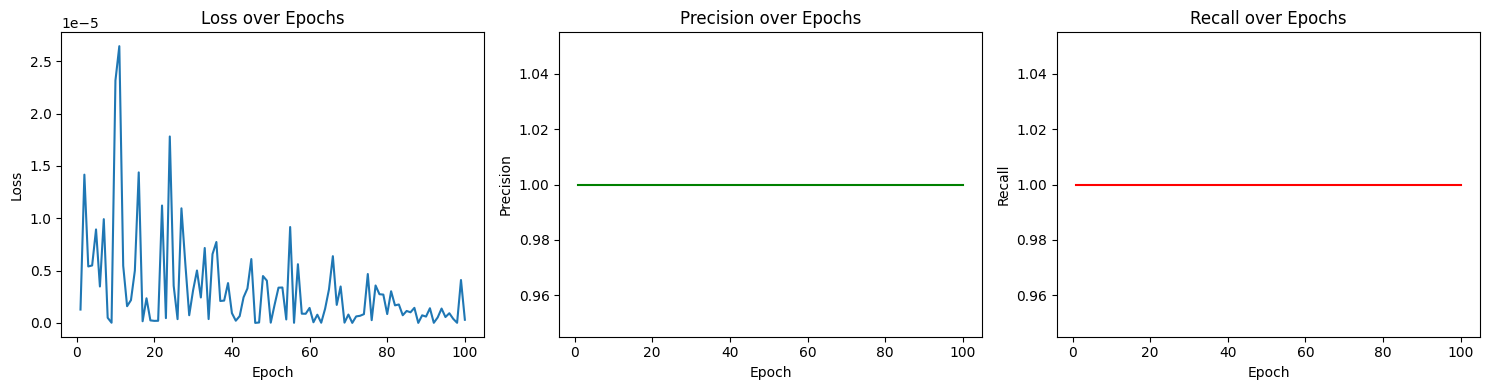

In [69]:
import matplotlib.pyplot as plt
import os

epochs = range(1, len(loss_history) + 1)
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')

plt.subplot(1, 3, 2)
plt.plot(epochs, precision_history, label='Precision', color='g')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs')

plt.subplot(1, 3, 3)
plt.plot(epochs, recall_history, label='Recall', color='r')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall over Epochs')

plt.tight_layout()

os.makedirs('images', exist_ok=True)
plt.savefig('images/training_curves.png')  # Save BEFORE show

plt.show()

# 6. Evaluate Model

## 6.1 Import Metrics

In [39]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [40]:
# Get a batch from the test data
test_input, test_value, test_label = next(iter(test_data))

In [41]:
y_pred = siamese_model.predict([test_input, test_value])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


In [42]:
# Post processing the predictions
[1 if i > 0.5 else 0 for i in y_pred]

[0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]

In [43]:
test_label

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1.],
      dtype=float32)>

## 6.3 Calculate Metrics

In [45]:
# Create a metric object
r = Recall()

# Calculate the recall
r.update_state(test_label, y_pred)
print(f"Recall: {r.result().numpy()}")

# Return the recall value
def get_recall():
    return r.result().numpy()

Recall: 1.0


In [46]:
# Create a metric object
p = Precision()

# Calculate the precision
p.update_state(test_label, y_pred)
print(f"Precision: {p.result().numpy()}")

# Return the precision value
def get_precision():
    return p.result().numpy()

Precision: 1.0


In [47]:
r = Recall()
p = Precision()

for test_input, test_value, test_label in test_data.as_numpy_iterator():
    y_pred = siamese_model.predict([test_input, test_value])
    
    # Update the metrics
    r.update_state(test_label, y_pred)
    p.update_state(test_label, y_pred)
print(f"Final Recall: {r.result().numpy()}")
print(f"Final Precision: {p.result().numpy()}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Final Recall: 1.0
Final Precision: 1.0


2025-05-26 23:59:29.901601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 6.4 Viz Results

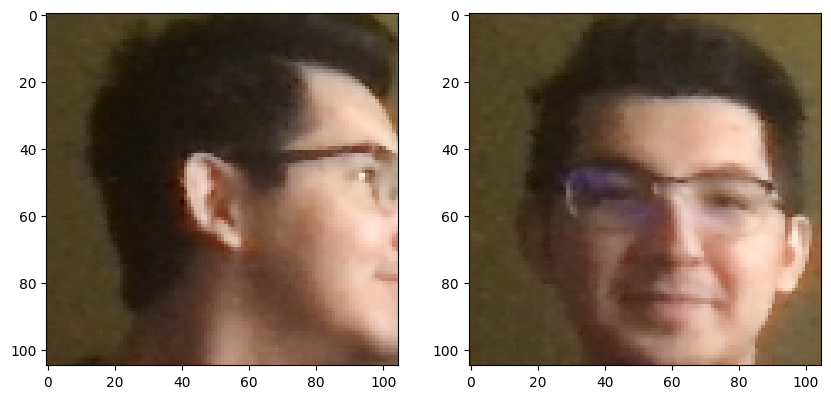

In [48]:
# Set plot size
plt.figure(figsize=(10, 10))

# Set first subplot
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1, 2, 2)
plt.imshow(test_value[0])

# Show the plots
plt.show()

# 7. Save Model

In [50]:
# Save the model weights
siamese_model.save('model_weights.h5')

In [51]:
L1Distance

__main__.L1Distance

In [52]:
# Reload the model
from tensorflow.keras.models import load_model
siamese_model = load_model('model_weights.h5', custom_objects={'L1Distance': L1Distance, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [53]:
# Make predictions with the reloaded model
siamese_model.predict([test_input, test_value])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999344e-01],
       [3.6041023e-10],
       [3.3597978e-09],
       [3.2814381e-08],
       [1.0000000e+00]], dtype=float32)

In [54]:
siamese_model.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_model     │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_distance_3       │ (None, 4096)      │          0 │ embedding_model[… │
│ (L1Distance)        │                   │            │ embedding_model[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │      4,097 │ l1_distance_3[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [57]:
os.makedirs('application_data/verification_images', exist_ok=True)

In [58]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [59]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [60]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

OpenCV: AVFoundation didn't find any attached Video Input Devices!
OpenCV: camera failed to properly initialize!


In [ ]:
np.sum(np.squeeze(results) > 0.9)

In [ ]:
results